In [1]:
import torch
import torch.nn as nn
import numpy as np

from warnings import filterwarnings

filterwarnings('ignore')

from itertools import chain
from typing import List, Tuple, Union

import pandas as pd

from tokenizers import Tokenizer
from tokenizers.models import BPE
from tokenizers.pre_tokenizers import Whitespace
from tokenizers.trainers import BpeTrainer
from tokenizers.normalizers import Lowercase

import torch
import torch.nn as nn
import torch.optim as optim


import random
import re
from collections import Counter

import gensim.downloader as api
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from IPython.display import clear_output
from torch.nn.utils.rnn import pad_sequence
from torch.optim import Adam
from torch.optim import Optimizer
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from tqdm import tqdm

In [2]:
import pandas as pd
data = pd.read_csv("/kaggle/input/mtech-data/mtech.csv", index_col = 0)

data = data.replace('Консультация КЦ', 0)
data = data.replace('Компетентность продавцов/ консультантов', 1)
data = data.replace('Электронная очередь', 2)
data = data.replace('Доступность персонала в магазине', 3)
data = data.replace('Вежливость сотрудников магазина', 4)
data = data.replace('Обслуживание на кассе', 5)
data = data.replace('Обслуживание продавцами/ консультантами', 6)
data = data.replace('Время ожидания у кассы', 7)

data.head()

,id,text,class
0,45,негатив к вам и горячей линии которые нафиг н...,0
1,97,перестаньте впаривать клиентам дополнительные ...,1
2,105,продавец предложил наклеить защитную плёнку з...,1
3,127,продавец режил продать нам товар почему то по ...,1
4,130,навязанные услуги ( без моего согласия) на сум...,1


In [3]:
data = data.rename(columns = {"class":"label"})

In [4]:
data["label"].value_counts()

label
1    825
4    500
7    306
3    293
6    267
2    264
5    212
0    170
Name: count, dtype: int64

In [5]:
ids = data["id"]

In [6]:
data = data.drop('id', axis=1)

In [7]:
from sklearn.model_selection import train_test_split

train, test  = train_test_split(data, train_size=0.9, random_state=42)
ids_train, ids_test = train_test_split(ids, train_size=0.9, random_state=42)

In [8]:
from transformers import AutoTokenizer

old_tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny")
new_tokenizer = old_tokenizer.train_new_from_iterator([f"{row.text}" for row in chain(train.itertuples(), test.itertuples())], 
                                                   vocab_size= 15000)
new_tokenizer.save_pretrained("/kaggle/working/bruhwalkk")

tokenizer_config.json:   0%|          | 0.00/341 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/632 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/241k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/468k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

('/kaggle/working/bruhwalkk/tokenizer_config.json',
 '/kaggle/working/bruhwalkk/special_tokens_map.json',
 '/kaggle/working/bruhwalkk/vocab.txt',
 '/kaggle/working/bruhwalkk/added_tokens.json',
 '/kaggle/working/bruhwalkk/tokenizer.json')

In [9]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("/kaggle/working/bruhwalkk")
tokenizer

BertTokenizerFast(name_or_path='/kaggle/working/bruhwalkk', vocab_size=15000, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	4: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

In [10]:
from datasets import Dataset

train = Dataset.from_pandas(train)
test = Dataset.from_pandas(test)

In [11]:
train = train.remove_columns(['__index_level_0__'])
test = test.remove_columns(['__index_level_0__'])

In [12]:
train = train.class_encode_column("label")
test = test.class_encode_column("label")

Stringifying the column:   0%|          | 0/3 [00:00<?, ?ba/s]

Casting to class labels:   0%|          | 0/3 [00:00<?, ?ba/s]

Casting the dataset:   0%|          | 0/1 [00:00<?, ?ba/s]

Stringifying the column:   0%|          | 0/1 [00:00<?, ?ba/s]

Casting to class labels:   0%|          | 0/1 [00:00<?, ?ba/s]

Casting the dataset:   0%|          | 0/1 [00:00<?, ?ba/s]

In [13]:
train.features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(num_classes=8, names=['0', '1', '2', '3', '4', '5', '6', '7'], id=None)}

In [14]:
idx_train = ids_train.tolist()
idx_test = ids_test.tolist()

In [15]:
from huggingface_hub import notebook_login
notebook_login()

In [16]:
from transformers import AutoModel

model = AutoModel.from_pretrained("cointegrated/rubert-tiny")

model.safetensors:   0%|          | 0.00/47.7M [00:00<?, ?B/s]

In [17]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)
print(torch.cuda.get_device_name())

model = model.to(device)

cuda:0
Tesla P100-PCIE-16GB


In [18]:
def tokenization(example):
    return tokenizer.batch_encode_plus(example['text'], add_special_tokens=True, return_token_type_ids=False, truncation=True)

In [19]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [20]:
from torch.utils.data import DataLoader
from torch.utils.data import Subset

train = train.map(tokenization, batched=True)
test = test.map(tokenization, batched=True)

train.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
test.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

train_loader = DataLoader(train,collate_fn=data_collator, shuffle = False)
test_loader = DataLoader(test,collate_fn=data_collator, shuffle = False)

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [21]:
train

Dataset({
    features: ['text', 'label', 'input_ids', 'attention_mask'],
    num_rows: 2553
})

In [22]:
test

Dataset({
    features: ['text', 'label', 'input_ids', 'attention_mask'],
    num_rows: 284
})

In [23]:
from tqdm import tqdm


@torch.inference_mode()
def get_embeddings_labels(model, loader):
    model.eval()
    
    total_embeddings = []
    labels = []
    
    for batch in tqdm(loader):
        labels.append(batch['labels'].unsqueeze(1))

        batch = {key: batch[key].to(device) for key in ['attention_mask', 'input_ids']}

        embeddings = model(**batch)['last_hidden_state'][:, 0, :]

        total_embeddings.append(embeddings.cpu())

    return torch.cat(total_embeddings, dim=0), torch.cat(labels, dim=0).to(torch.float32)

In [24]:
np.object = object

In [25]:
train_embeddings, train_labels = get_embeddings_labels(model, train_loader)
test_embeddings, test_labels = get_embeddings_labels(model, test_loader)

100%|██████████| 284/284 [00:00<00:00, 316.28it/s]


In [26]:
train_embeddings.shape

torch.Size([2553, 312])

In [27]:
torch.save(train_embeddings, "embedding_distilbert.pt")

In [28]:
from torch.utils.data import TensorDataset
from torch.utils.data import random_split


dataset = TensorDataset(torch.cat([train_embeddings, test_embeddings], dim=0), torch.cat([train_labels, test_labels], dim=0))

train_dataset, test_dataset = random_split(dataset, (int(len(dataset) * 0.9), len(dataset) - int(len(dataset) * 0.9)))

train_loader = DataLoader(train_dataset, batch_size=128, pin_memory=True, shuffle=True)
valid_loader = DataLoader(test_dataset, batch_size=128, pin_memory=True, shuffle=False)

In [29]:
little_model = nn.Sequential(
    nn.Linear(312, 312),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(312, 8)
)

In [30]:
def multiclass_accuracy(preds, y):
    _, predicted = torch.max(preds, 1)
    correct = (predicted == y).float()
    acc = correct.sum() / len(correct)
    return acc


def train(model):
    model.train()

    train_loss = 0
    train_accuracy = 0

    for x, y in tqdm(train_loader, desc='Train'):
        x, y = x.to(device), y.to(device)
        y = y.squeeze(1)
        y = y.long()
        optimizer.zero_grad()

        output = model(x)

        loss = loss_fn(output, y)

        train_loss += loss.item()
        train_accuracy += multiclass_accuracy(output, y).cpu()

        loss.backward()

        optimizer.step()

    train_loss /= len(train_loader)
    train_accuracy /= len(train_loader)

    return train_loss, train_accuracy

In [31]:
@torch.inference_mode()
def evaluate(model, loader):
    model.eval()

    total_loss = 0
    total_accuracy = 0

    for x, y in tqdm(loader, desc='Evaluation'):
        
        x, y = x.to(device), y.to(device)
        
        y = y.squeeze(1)
        y = y.long()

        output = model(x)

        loss = loss_fn(output, y)

        total_loss += loss.item()
        total_accuracy += multiclass_accuracy(output, y).cpu()

    total_loss /= len(loader)
    total_accuracy /= len(loader)

    return total_loss, total_accuracy

In [32]:
import matplotlib.pyplot as plt
from IPython.display import clear_output


def plot_stats(
    train_loss: list[float],
    valid_loss: list[float],
    train_accuracy: list[float],
    valid_accuracy: list[float],
    title: str
):
    plt.figure(figsize=(16, 8))

    plt.title(title + ' loss')

    plt.plot(train_loss, label='Train loss')
    plt.plot(valid_loss, label='Valid loss')
    plt.legend()
    plt.grid()

    plt.show()

    plt.figure(figsize=(16, 8))

    plt.title(title + ' accuracy')
    
    plt.plot(train_accuracy, label='Train accuracy')
    plt.plot(valid_accuracy, label='Valid accuracy')
    plt.legend()
    plt.grid()

    plt.show()

In [33]:
def whole_train_valid_cycle(model, num_epochs, title):
    train_loss_history, valid_loss_history = [], []
    train_accuracy_history, valid_accuracy_history = [], []

    for epoch in range(num_epochs):
        train_loss, train_accuracy = train(model)
        valid_loss, valid_accuracy = evaluate(model, valid_loader)

        train_loss_history.append(train_loss)
        valid_loss_history.append(valid_loss)

        train_accuracy_history.append(train_accuracy)
        valid_accuracy_history.append(valid_accuracy)

        clear_output()

        plot_stats(
            train_loss_history, valid_loss_history,
            train_accuracy_history, valid_accuracy_history,
            title
        )

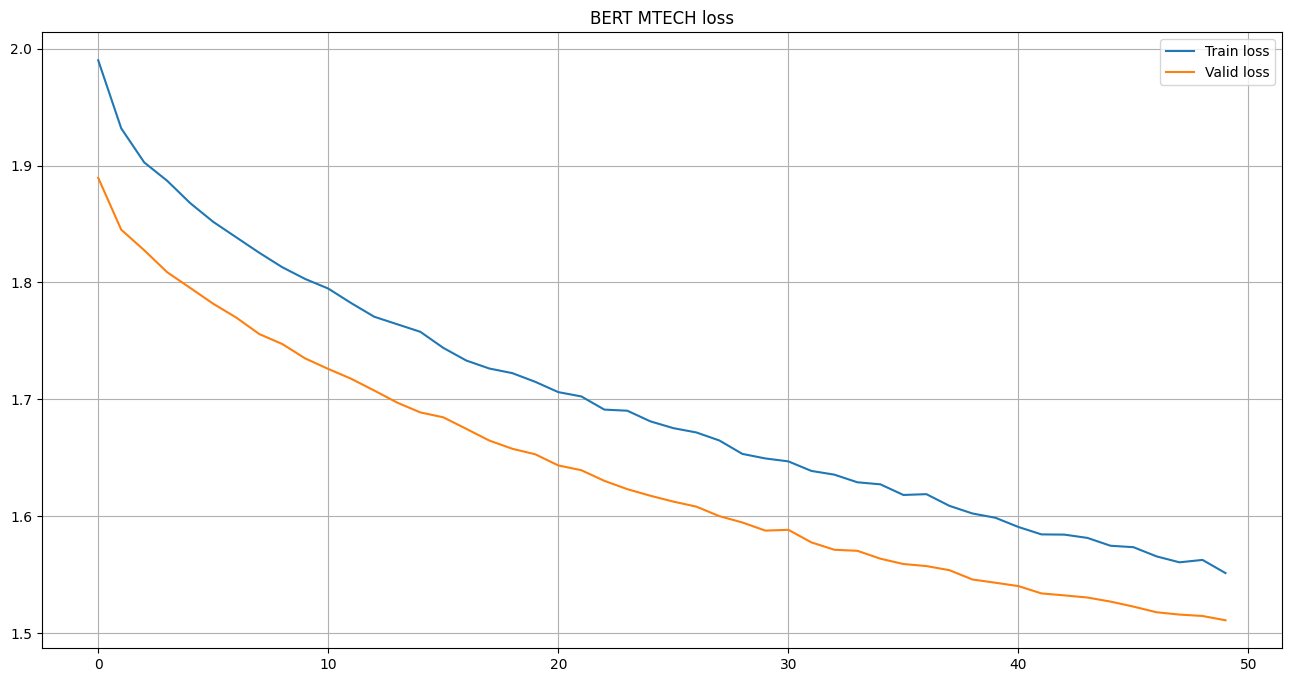

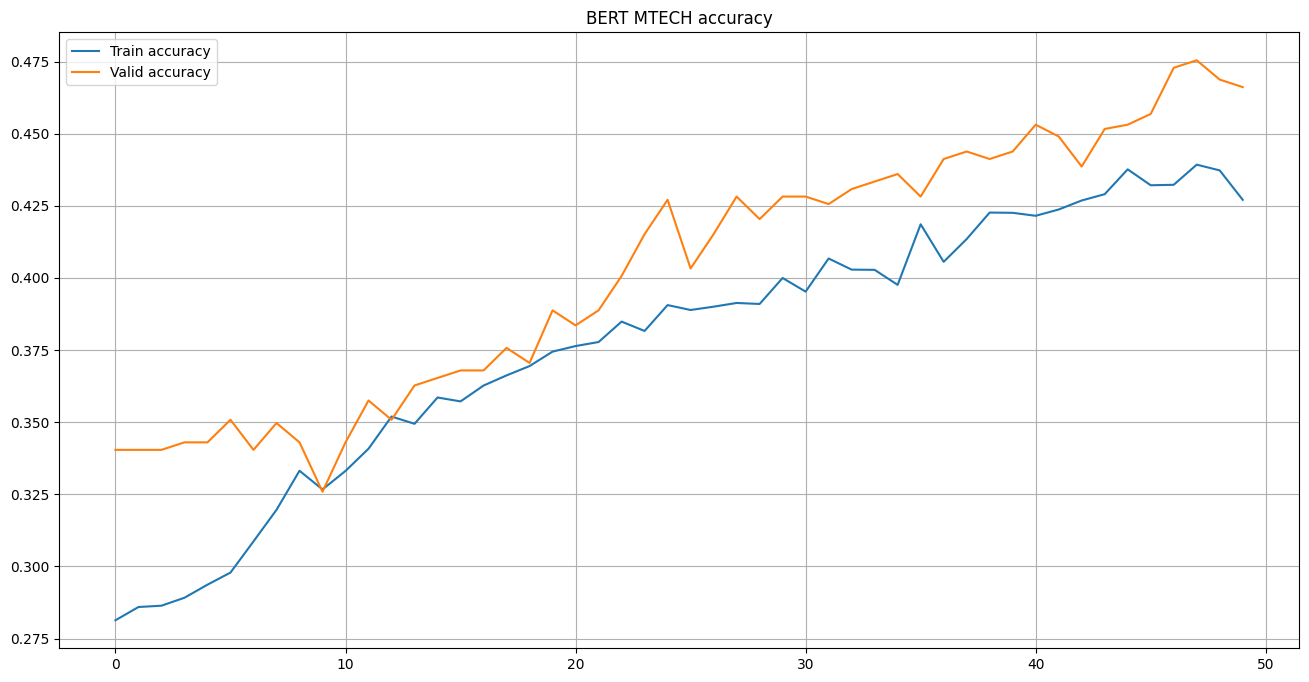

In [34]:
from torch.optim import Adam


little_model = little_model.to(device)

optimizer = Adam(little_model.parameters(), lr=1e-4)
loss_fn = nn.CrossEntropyLoss()

whole_train_valid_cycle(little_model, 50, 'BERT MTECH')

In [35]:
torch.save(little_model, 'model.pth')

In [36]:
model = torch.load('model.pth')
model.to("cpu")
model.eval()

Sequential(
  (0): Linear(in_features=312, out_features=312, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.2, inplace=False)
  (3): Linear(in_features=312, out_features=8, bias=True)
)

In [37]:
import torch
from transformers import AutoTokenizer, AutoModel

# Предположим, что у вас есть следующие объекты
bert_model = AutoModel.from_pretrained("cointegrated/rubert-tiny")  # Пример BERT модели
# Ваша модель классификации
tokenizer = AutoTokenizer.from_pretrained("/kaggle/working/bruhwalkk")  # Пример токенизатора

def classify_sentence(sentence, bert_model, little_model, tokenizer):
    
    labels = ['Консультация КЦ',
               'Компетентность продавцов/ консультантов',
               'Электронная очередь',
               'Доступность персонала в магазине',
               'Вежливость сотрудников магазина',
               'Обслуживание на кассе',
               'Обслуживание продавцами/ консультантами',
               'Время ожидания у кассы']
    
    # Токенизация предложения
    inputs = tokenizer(sentence,return_tensors="pt")

    # Получение эмбеддингов от BERT модели
    with torch.no_grad():
        outputs = bert_model(**inputs)
    
    # Использование первого токена (CLS) для классификации
    embeddings = outputs.last_hidden_state[:, 0, :]

    # Предсказание класса с помощью второй модели
    with torch.no_grad():
        class_logits = little_model(embeddings)
    
    # Преобразование логитов в вероятности
    probabilities = torch.softmax(class_logits, dim=1)

    # Получение индекса наиболее вероятного класса
    predicted_class = torch.argmax(probabilities, dim=1).item()

    return labels[predicted_class],predicted_class, probabilities

# Пример использования функции
sentence = "обслужили плохо товар потеряли"
label,predicted_class, probabilities = classify_sentence(sentence, bert_model, model, tokenizer)
print(f"Predicted class: {label}, {predicted_class}, Probabilities: {probabilities}")


Predicted class: Компетентность продавцов/ консультантов, 1, Probabilities: tensor([[0.0430, 0.2798, 0.0270, 0.1789, 0.2449, 0.0617, 0.0962, 0.0685]])
